In [55]:
import logging
import os
from slimit.lexer import Lexer
from calmjs.parse.lexers.es5 import Lexer as ES5Lexer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import manifold
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
from dotenv import load_dotenv
load_dotenv()

os.chdir(os.getenv("PROJECT_ROOT_DIR"))
print(os.getcwd())

/home/truonghm/learning/m1-internship/malicious-code-detection


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from lib.dataset import CodeDirectoryCorpus

In [90]:
corpus = CodeDirectoryCorpus('data/all', exclude_pattern="badHTML", sampling=1, seed=42)

In [91]:
len(corpus)

176

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

class TfIdfProcessor:
    def __init__(self, corpus):
        self.corpus = corpus
        self._train()

    def _tokenize_corpus(self):
        return [' '.join([token[0] for token in text.tokens]) for text in self.corpus.get_texts()]

    def _train(self):
        tokens_corpus = self._tokenize_corpus()
        self.count_vect = CountVectorizer()
        train_counts = self.count_vect.fit_transform(tokens_corpus)
        self.tfidf_transformer = TfidfTransformer().fit(train_counts)

    def text2tfidf(self, text_list):
        """Transform a list of text into a tfidf matrix"""
        return self.tfidf_transformer.transform(self.count_vect.transform(text_list)).toarray()


In [36]:
tfidf_transformer = TfIdfProcessor(corpus)

data/all/goodjs/50861667794181.9095404: Line 1: Unexpected token ILLEGAL


In [98]:
from gensim.models import Word2Vec
import numpy as np

def get_token_type(corpus):
    codes = []
    for code in corpus:
        codes.append([token[0] for token in code.tokens])
    return codes

def train_word2vec(corpus, vector_size=100, window=5, min_count=1, workers=4):
    tokens = get_token_type(corpus)
    model = Word2Vec(sentences=tokens, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

def text_to_vector(model, text_tokens):
    vector = np.mean([model.wv[token] for token in text_tokens if token in model.wv.index_to_key], axis=0)
    return vector

def corpus_to_vectors(model, corpus):
    tokens = get_token_type(corpus)
    return np.array([text_to_vector(model, text) for text in tokens])


In [96]:
# Usage
word2vec_model = train_word2vec(corpus)

data/all/goodjs/83471667796793.2066796: Line 1: Unexpected token ILLEGAL
Error decoding file: data/all/goodjs/11871667790582.8567448


In [99]:
# X = corpus_to_vectors(word2vec_model, corpus)

# X_0 = tfidf_transformer.text2tfidf([s.snippet for s in corpus.get_texts(label=0)])
# X_1 = tfidf_transformer.text2tfidf([s.snippet for s in corpus.get_texts(label=1)])

X_0 = corpus_to_vectors(word2vec_model, corpus.get_texts(label=0))
X_1 = corpus_to_vectors(word2vec_model, corpus.get_texts(label=1))

X = np.vstack([X_0, X_1])
Y =np.zeros(len(X))
Y[-len(X_1):] = 1

data/all/goodjs/83471667796793.2066796: Line 1: Unexpected token ILLEGAL
Error decoding file: data/all/goodjs/11871667790582.8567448
Error decoding file: data/all/goodjs/11871667790582.8567448


In [40]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [72]:
def clf_eval(clf, X, Y):
    loo = LeaveOneOut()
    Y_true = []
    Y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Y_pred.append(clf.predict(X_test))
        Y_true.append(Y_test)
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)
    cm =  metrics.confusion_matrix(Y_true, Y_pred)
    print("Overall accuracy : "+str(sum(Y_true == Y_pred)/len(Y_true)))
    return cm


results = {}
for clf in [
    LinearSVC,
    KNeighborsClassifier,
    SVC,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
]:
    print(clf.__name__)
    results[clf.__name__] = clf_eval(clf(), X, Y)

LinearSVC
Overall accuracy : [0.62666667]
KNeighborsClassifier
Overall accuracy : [0.57333333]
SVC
Overall accuracy : [0.66666667]
BaggingClassifier
Overall accuracy : [0.32]
RandomForestClassifier
Overall accuracy : [0.33333333]
ExtraTreesClassifier
Overall accuracy : [0.33333333]
AdaBoostClassifier
Overall accuracy : [0.32]
GradientBoostingClassifier
Overall accuracy : [0.33333333]


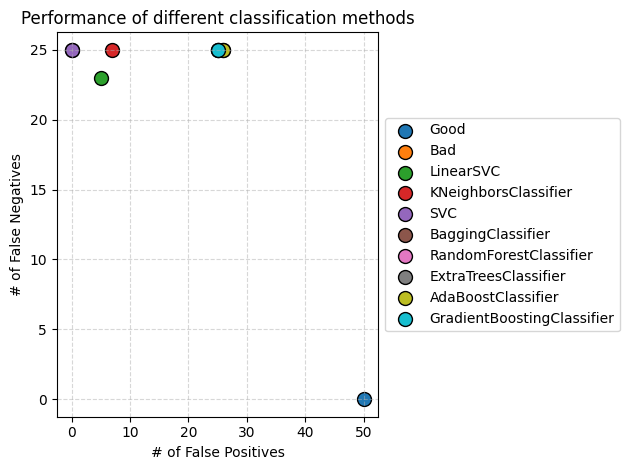

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.values())

results_fpfn = {}
results_fpfn['Good'] = [len(X_0), 0]
results_fpfn['Bad'] = [0, len(X_1)]
for k in results:
    results_fpfn[k] = [results[k][0, 1], results[k][1, 0]]

for idx, (label, values) in enumerate(results_fpfn.items()):
    plt.scatter(values[0], values[1], s=100, c=colors[idx % len(colors)], label=label, edgecolors='black')

plt.title("Performance of different classification methods")
plt.xlabel("# of False Positives")
plt.ylabel("# of False Negatives")
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
